In [1]:
from env import load_uavs, load_tasks, initialize_targets
from runEnv import UAVEnv

In [2]:
# 设置数据目录
uav_csv = "data/uav.csv"
task_csv = "data/task.csv"
uavs = load_uavs(uav_csv)
target = initialize_targets(load_tasks(task_csv))

# 俩个模式：DQN和Attention
dqn_mode = "dqn"
attention_mode = "attention"
env = UAVEnv(uavs, target, mode=attention_mode)

In [3]:
"""
运行 DQN 优化
"""
from train.dqn_train import train_dqn
# model = train_dqn(env)

Episode 0 | Total Reward: 0.08 | Total Distance: 13827.36 | Total Success : 0.17 | Epsilon: 0.995
Episode 1 | Total Reward: 0.09 | Total Distance: 13197.69 | Total Success : 0.17 | Epsilon: 0.990
Episode 2 | Total Reward: 0.15 | Total Distance: 13571.98 | Total Success : 0.27 | Epsilon: 0.985
Episode 3 | Total Reward: 0.12 | Total Distance: 13373.12 | Total Success : 0.23 | Epsilon: 0.980
Episode 4 | Total Reward: 0.21 | Total Distance: 12055.04 | Total Success : 0.33 | Epsilon: 0.975
Episode 5 | Total Reward: 0.05 | Total Distance: 13690.12 | Total Success : 0.10 | Epsilon: 0.970
Episode 6 | Total Reward: 0.10 | Total Distance: 13150.19 | Total Success : 0.20 | Epsilon: 0.966
Episode 7 | Total Reward: 0.05 | Total Distance: 12911.87 | Total Success : 0.10 | Epsilon: 0.961
Episode 8 | Total Reward: 0.19 | Total Distance: 12139.49 | Total Success : 0.23 | Epsilon: 0.956
Episode 9 | Total Reward: 0.09 | Total Distance: 13780.01 | Total Success : 0.13 | Epsilon: 0.951
Episode 10 | Total R

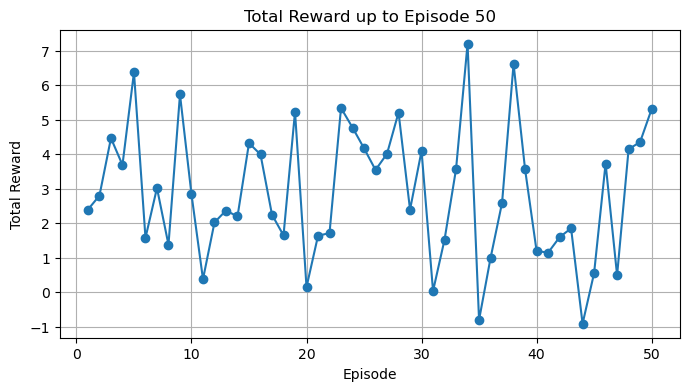

Episode 50 | Total Reward: 0.17 | Total Distance: 13740.27 | Total Success : 0.23 | Epsilon: 0.774
Episode 51 | Total Reward: 0.01 | Total Distance: 13704.19 | Total Success : 0.10 | Epsilon: 0.771
Episode 52 | Total Reward: 0.15 | Total Distance: 10980.42 | Total Success : 0.20 | Epsilon: 0.767
Episode 53 | Total Reward: 0.11 | Total Distance: 13454.77 | Total Success : 0.17 | Epsilon: 0.763
Episode 54 | Total Reward: 0.07 | Total Distance: 13409.94 | Total Success : 0.17 | Epsilon: 0.759
Episode 55 | Total Reward: 0.11 | Total Distance: 12227.44 | Total Success : 0.13 | Epsilon: 0.755
Episode 56 | Total Reward: 0.05 | Total Distance: 11161.01 | Total Success : 0.10 | Epsilon: 0.751
Episode 57 | Total Reward: 0.06 | Total Distance: 12825.08 | Total Success : 0.13 | Epsilon: 0.748
Episode 58 | Total Reward: 0.10 | Total Distance: 11849.79 | Total Success : 0.17 | Epsilon: 0.744
Episode 59 | Total Reward: 0.11 | Total Distance: 12067.18 | Total Success : 0.13 | Epsilon: 0.740
Episode 60

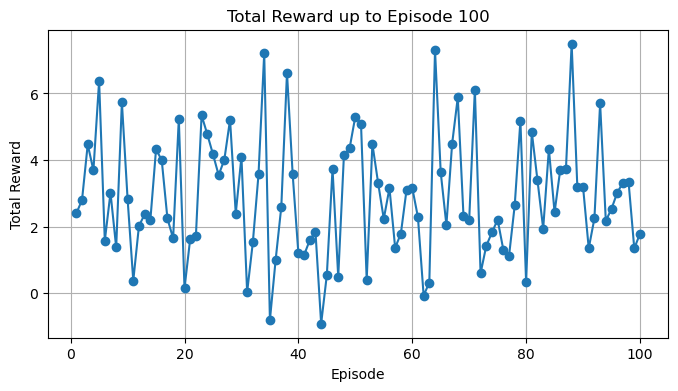

Episode 100 | Total Reward: 0.13 | Total Distance: 11390.71 | Total Success : 0.23 | Epsilon: 0.603
Episode 101 | Total Reward: 0.09 | Total Distance: 11716.15 | Total Success : 0.17 | Epsilon: 0.600
Episode 102 | Total Reward: 0.13 | Total Distance: 13382.52 | Total Success : 0.23 | Epsilon: 0.597
Episode 103 | Total Reward: 0.08 | Total Distance: 13496.42 | Total Success : 0.20 | Epsilon: 0.594
Episode 104 | Total Reward: 0.22 | Total Distance: 11145.15 | Total Success : 0.30 | Epsilon: 0.591
Episode 105 | Total Reward: 0.12 | Total Distance: 11268.34 | Total Success : 0.20 | Epsilon: 0.588
Episode 106 | Total Reward: 0.25 | Total Distance: 12732.09 | Total Success : 0.33 | Epsilon: 0.585
Episode 107 | Total Reward: 0.07 | Total Distance: 12221.54 | Total Success : 0.10 | Epsilon: 0.582
Episode 108 | Total Reward: 0.04 | Total Distance: 11071.28 | Total Success : 0.07 | Epsilon: 0.579
Episode 109 | Total Reward: 0.19 | Total Distance: 11814.97 | Total Success : 0.27 | Epsilon: 0.576


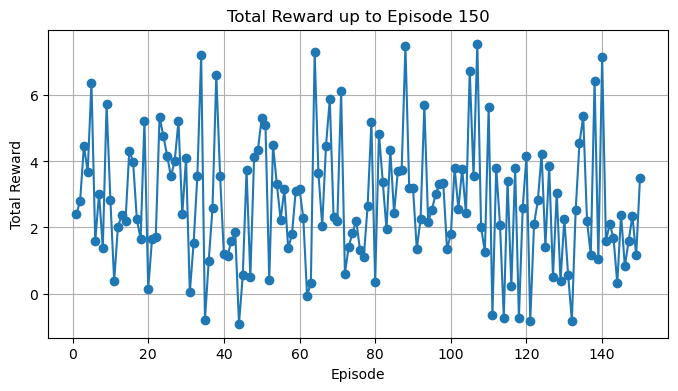

Episode 150 | Total Reward: 0.01 | Total Distance: 10749.72 | Total Success : 0.07 | Epsilon: 0.469
Episode 151 | Total Reward: 0.08 | Total Distance: 8158.98 | Total Success : 0.10 | Epsilon: 0.467
Episode 152 | Total Reward: 0.15 | Total Distance: 9842.12 | Total Success : 0.20 | Epsilon: 0.464
Episode 153 | Total Reward: 0.04 | Total Distance: 13112.08 | Total Success : 0.10 | Epsilon: 0.462
Episode 154 | Total Reward: 0.05 | Total Distance: 12166.13 | Total Success : 0.10 | Epsilon: 0.460
Episode 155 | Total Reward: 0.11 | Total Distance: 11148.34 | Total Success : 0.13 | Epsilon: 0.458
Episode 156 | Total Reward: 0.08 | Total Distance: 9963.66 | Total Success : 0.10 | Epsilon: 0.455
Episode 157 | Total Reward: 0.07 | Total Distance: 10458.51 | Total Success : 0.13 | Epsilon: 0.453
Episode 158 | Total Reward: 0.05 | Total Distance: 10862.34 | Total Success : 0.13 | Epsilon: 0.451
Episode 159 | Total Reward: 0.02 | Total Distance: 10099.64 | Total Success : 0.07 | Epsilon: 0.448
Epi

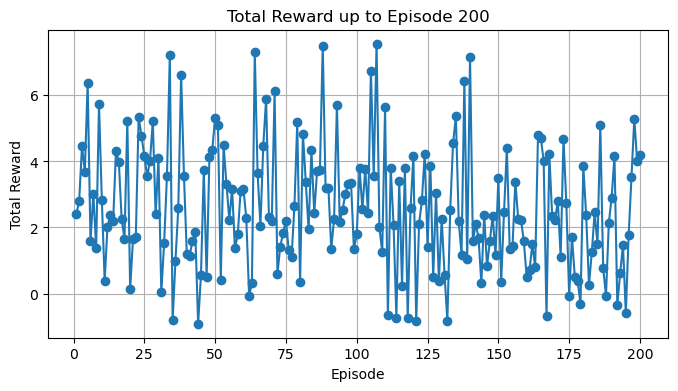

Episode 200 | Total Reward: 0.08 | Total Distance: 10367.16 | Total Success : 0.10 | Epsilon: 0.365
Episode 201 | Total Reward: 0.08 | Total Distance: 8195.44 | Total Success : 0.10 | Epsilon: 0.363
Episode 202 | Total Reward: 0.06 | Total Distance: 11478.29 | Total Success : 0.13 | Epsilon: 0.361
Episode 203 | Total Reward: 0.11 | Total Distance: 10669.69 | Total Success : 0.20 | Epsilon: 0.360
Episode 204 | Total Reward: 0.11 | Total Distance: 12593.77 | Total Success : 0.17 | Epsilon: 0.358
Episode 205 | Total Reward: -0.03 | Total Distance: 11928.40 | Total Success : 0.00 | Epsilon: 0.356
Episode 206 | Total Reward: 0.03 | Total Distance: 12447.07 | Total Success : 0.10 | Epsilon: 0.354
Episode 207 | Total Reward: 0.06 | Total Distance: 9223.93 | Total Success : 0.13 | Epsilon: 0.353
Episode 208 | Total Reward: 0.29 | Total Distance: 13660.00 | Total Success : 0.43 | Epsilon: 0.351
Episode 209 | Total Reward: 0.04 | Total Distance: 12620.33 | Total Success : 0.10 | Epsilon: 0.349
E

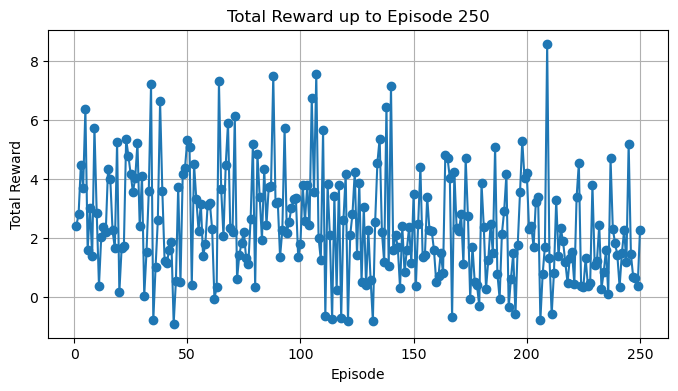

Episode 250 | Total Reward: 0.11 | Total Distance: 9133.77 | Total Success : 0.17 | Epsilon: 0.284
Episode 251 | Total Reward: 0.09 | Total Distance: 10161.06 | Total Success : 0.13 | Epsilon: 0.283
Episode 252 | Total Reward: 0.09 | Total Distance: 10852.97 | Total Success : 0.17 | Epsilon: 0.281
Episode 253 | Total Reward: 0.05 | Total Distance: 10087.85 | Total Success : 0.10 | Epsilon: 0.280
Episode 254 | Total Reward: 0.03 | Total Distance: 8947.21 | Total Success : 0.10 | Epsilon: 0.279
Episode 255 | Total Reward: -0.02 | Total Distance: 10510.50 | Total Success : 0.03 | Epsilon: 0.277
Episode 256 | Total Reward: 0.01 | Total Distance: 11706.37 | Total Success : 0.07 | Epsilon: 0.276
Episode 257 | Total Reward: 0.05 | Total Distance: 9322.75 | Total Success : 0.07 | Epsilon: 0.274
Episode 258 | Total Reward: 0.08 | Total Distance: 9397.29 | Total Success : 0.13 | Epsilon: 0.273
Episode 259 | Total Reward: 0.01 | Total Distance: 11851.34 | Total Success : 0.07 | Epsilon: 0.272
Epi

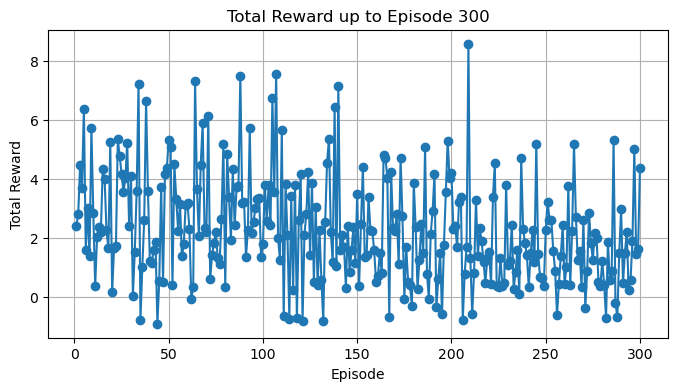

Episode 300 | Total Reward: -0.02 | Total Distance: 9262.04 | Total Success : 0.00 | Epsilon: 0.221
Episode 301 | Total Reward: 0.05 | Total Distance: 10189.27 | Total Success : 0.10 | Epsilon: 0.220
Episode 302 | Total Reward: 0.04 | Total Distance: 10066.89 | Total Success : 0.07 | Epsilon: 0.219
Episode 303 | Total Reward: -0.02 | Total Distance: 9305.54 | Total Success : 0.00 | Epsilon: 0.218
Episode 304 | Total Reward: 0.05 | Total Distance: 7142.18 | Total Success : 0.07 | Epsilon: 0.217
Episode 305 | Total Reward: 0.02 | Total Distance: 7792.70 | Total Success : 0.07 | Epsilon: 0.216
Episode 306 | Total Reward: -0.01 | Total Distance: 9919.37 | Total Success : 0.03 | Epsilon: 0.215
Episode 307 | Total Reward: -0.02 | Total Distance: 6957.23 | Total Success : 0.00 | Epsilon: 0.214
Episode 308 | Total Reward: 0.09 | Total Distance: 10155.48 | Total Success : 0.13 | Epsilon: 0.212
Episode 309 | Total Reward: 0.00 | Total Distance: 10334.86 | Total Success : 0.03 | Epsilon: 0.211
Ep

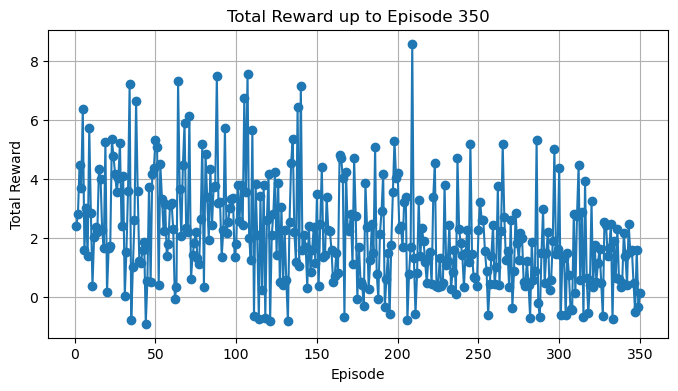

Episode 350 | Total Reward: 0.09 | Total Distance: 7995.30 | Total Success : 0.13 | Epsilon: 0.172
Episode 351 | Total Reward: 0.05 | Total Distance: 11003.74 | Total Success : 0.10 | Epsilon: 0.171
Episode 352 | Total Reward: 0.05 | Total Distance: 7958.90 | Total Success : 0.07 | Epsilon: 0.170
Episode 353 | Total Reward: 0.06 | Total Distance: 5763.09 | Total Success : 0.10 | Epsilon: 0.170
Episode 354 | Total Reward: 0.05 | Total Distance: 9884.17 | Total Success : 0.10 | Epsilon: 0.169
Episode 355 | Total Reward: 0.05 | Total Distance: 7235.80 | Total Success : 0.07 | Epsilon: 0.168
Episode 356 | Total Reward: 0.06 | Total Distance: 8046.44 | Total Success : 0.10 | Epsilon: 0.167
Episode 357 | Total Reward: 0.02 | Total Distance: 9207.83 | Total Success : 0.07 | Epsilon: 0.166
Episode 358 | Total Reward: 0.04 | Total Distance: 10984.37 | Total Success : 0.10 | Epsilon: 0.165
Episode 359 | Total Reward: 0.01 | Total Distance: 9891.90 | Total Success : 0.03 | Epsilon: 0.165
Episode 

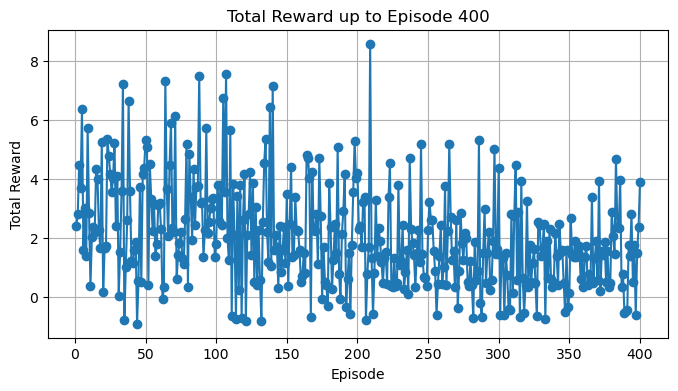

Episode 400 | Total Reward: -0.02 | Total Distance: 7981.36 | Total Success : 0.00 | Epsilon: 0.134
Episode 401 | Total Reward: 0.05 | Total Distance: 6238.59 | Total Success : 0.07 | Epsilon: 0.133
Episode 402 | Total Reward: 0.12 | Total Distance: 8138.70 | Total Success : 0.17 | Epsilon: 0.133
Episode 403 | Total Reward: 0.05 | Total Distance: 6119.71 | Total Success : 0.13 | Epsilon: 0.132
Episode 404 | Total Reward: -0.02 | Total Distance: 9043.93 | Total Success : 0.03 | Epsilon: 0.131
Episode 405 | Total Reward: -0.01 | Total Distance: 7893.13 | Total Success : 0.00 | Epsilon: 0.131
Episode 406 | Total Reward: -0.02 | Total Distance: 6999.96 | Total Success : 0.00 | Epsilon: 0.130
Episode 407 | Total Reward: 0.06 | Total Distance: 6712.52 | Total Success : 0.13 | Epsilon: 0.129
Episode 408 | Total Reward: -0.01 | Total Distance: 4992.71 | Total Success : 0.00 | Epsilon: 0.129
Episode 409 | Total Reward: -0.02 | Total Distance: 8408.09 | Total Success : 0.00 | Epsilon: 0.128
Epis

In [ ]:
"""
运行 AttentionDQN 优化
"""
from train.attention_train import train_attention_dqn
model = train_attention_dqn(env)

In [ ]:
"""
运行 PSO 优化
"""
from model.pso import PSO
# pso = PSO(env, num_particles=30, max_iter=100)
# best_position, best_fitness = pso.optimize()

In [ ]:
"""
运行 RR 轮询算法
"""
from model.rr import round_robin_allocation
# round_robin_allocation(env)